<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/hja_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
disturbance = pd.read_csv('/content/drive/MyDrive/summarized_disturbance_output_with_env_var.csv')

<ipython-input-3-797b7389ca66>:1: DtypeWarning: Columns (20,33,40) have mixed types. Specify dtype option on import or set low_memory=False.
  disturbance = pd.read_csv('/content/drive/MyDrive/summarized_disturbance_output_with_env_var.csv')


In [4]:
HJA_summary = pd.read_csv('/content/drive/MyDrive/HJA_Resources/HJA_summary.csv')

In [5]:
study = gpd.read_file('/content/drive/MyDrive/HJA_Resources/study_subset.gpkg')

In [6]:
HJA_wnf_dist = gpd.read_file('/content/drive/MyDrive/HJA_Resources/clip_wnfveg6.gpkg')

In [7]:
HJA_only_wnf_dist = gpd.overlay(study[study['HUC12'] == '170900040401'], HJA_wnf_dist.to_crs(study.crs), how='intersection')


In [8]:
full_disturbance = gpd.read_file('/content/drive/MyDrive/HJA_Resources/yod_vector__vectorized.gpkg')

In [9]:
study_full_disturbance = gpd.overlay(study, full_disturbance.to_crs(study.crs), how='intersection')

In [10]:
HJA_only_wnf_dist['area_orig'] = HJA_only_wnf_dist['AREA']
HJA_only_wnf_dist['area_int_calc'] = HJA_only_wnf_dist.to_crs(26910).area

In [11]:
HJA_summary.columns

Index(['Unnamed: 0', 'agbd', 'lat_lowestmode', 'lon_lowestmode',
       'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'agbd_t', 'agbd_t_se',
       'algorithm_run_flag', 'channel', 'degrade_flag', 'delta_time',
       'elev_lowestmode', 'l2_quality_flag', 'l4_quality_flag', 'gedi_year',
       'min_yod', 'min_mag', 'min_dur', 'min_preval', 'min_rate', 'min_dsnr',
       'max_yod', 'max_mag', 'max_dur', 'max_preval', 'max_rate', 'max_dsnr',
       'mean_yod', 'mean_mag', 'mean_dur', 'mean_preval', 'mean_rate',
       'mean_dsnr', 'median_yod', 'median_mag', 'median_dur', 'median_preval',
       'median_rate', 'median_dsnr', 'min_hja_2008', 'max_hja_2008',
       'mean_hja_2008', 'median_hja_2008', 'min_conus_2003', 'max_conus_2003',
       'mean_conus_2003', 'median_conus_2003', 'min_conus_2016',
       'max_conus_2016', 'mean_conus_2016', 'median_conus_2016', 'gedi_vec_id',
       'gedi_vec_year', 'gedi_vec_area', 'FIRE_INC_ID', 'FIRE_NAME',
       'FIRE_YEAR', 'geom', 'HUC8', 'HUC10', 

Slope: 4.1471, Intercept: 23.6726
Slope: 4.4237, Intercept: -26.2086
Slope: 4.6774, Intercept: 9.6943
Slope: 3.5073, Intercept: 14.3231
Slope: 5.6890, Intercept: -352.4920
Slope: -0.0153, Intercept: 630.8859


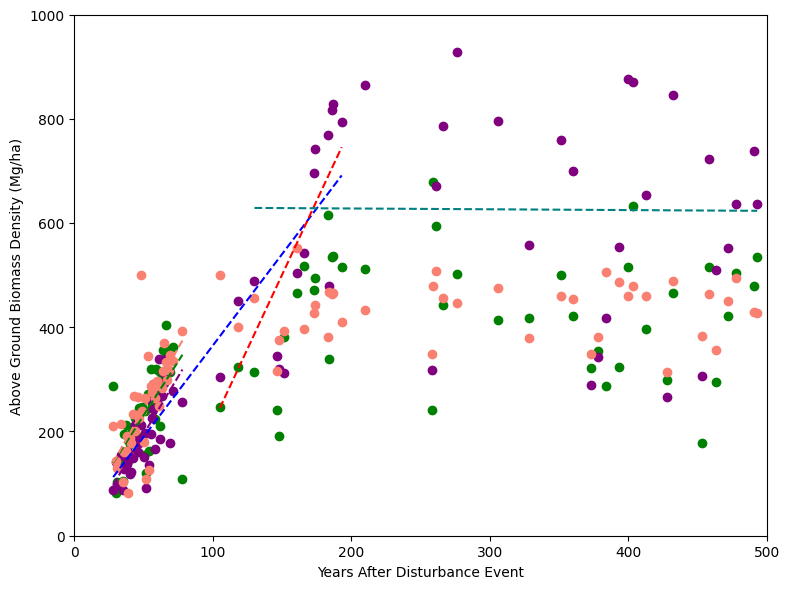

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Assuming `hja_summary_dt` is your input DataFrame. Replace this with your actual data.
# Sample structure for demonstration
# data = {
#     "wnf_year": [10, 20, 30, 40, 50],
#     "gedi_year": [2023, 2023, 2023, 2023, 2023],
#     "agbd": [200, 400, 600, 800, 1000],
#     "mean_conus_2003": [150, 300, 450, 600, 750],
#     "mean_hja_2008": [180, 360, 540, 720, 900],
#     "mean_conus_2016": [170, 340, 510, 680, 850],
# }
# hja_summary_dt = pd.DataFrame(data)

# Filter and calculate means as in R
filtered_df = HJA_summary[HJA_summary['wnf_year'] > 0].copy()
filtered_df['Years_After_Disturbance'] = 2023 - filtered_df['wnf_year']


# Group by `wnf_year` and `gedi_year` and calculate means
grouped_df = (
    filtered_df.groupby(["wnf_year"], as_index=False)
    .agg(
        agbd=("agbd", "mean"),
        mean_2003=("mean_conus_2003", "mean"),
        mean_2008=("mean_hja_2008", "mean"),
        mean_2016=("mean_conus_2016", "mean"),
    )
)
grouped_df["Years_After_Disturbance"] = 2023 - grouped_df["wnf_year"]

# Define colors for lines
color_mapping = {
    "GEDI": "green",
    "ALS, 2008": "purple",
    "MODIS 2003": "red",
    "LS, 2016": "salmon",
}

from sklearn.linear_model import LinearRegression
import numpy as np

# Function to fit regression, plot line, and print slope/intercept
def add_regression(df, x_col, y_col, label, color, ax, xlim=None):
    # Filter the data to the requested range
    if xlim:
        df = df[(df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])]

    # Fit regression
    X = df[[x_col]].values
    y = df[y_col].values
    model = LinearRegression().fit(X, y)
    x_range = np.linspace(df[x_col].min(), df[x_col].max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)

    # Print slope and intercept
    print(f"Slope: {model.coef_[0]:.4f}, Intercept: {model.intercept_:.4f}")

    # Plot regression line
    ax.plot(x_range, y_pred, color=color, linestyle="--", label=f"{label} (R²={model.score(X, y):.2f})")


# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter points
ax.scatter(grouped_df["Years_After_Disturbance"], grouped_df["agbd"], label="GEDI", color=color_mapping["GEDI"])
ax.scatter(grouped_df["Years_After_Disturbance"], grouped_df["mean_2008"], label="ALS, 2008", color=color_mapping["ALS, 2008"])
ax.scatter(grouped_df["Years_After_Disturbance"], grouped_df["mean_2016"], label="LS, 2016", color=color_mapping["LS, 2016"])

# Add regressions
add_regression(grouped_df, "Years_After_Disturbance", "agbd", "GEDI (0-100)", color_mapping["GEDI"], ax, xlim=(0, 100))
add_regression(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (0-100)", color_mapping["ALS, 2008"], ax, xlim=(0, 100))
add_regression(grouped_df, "Years_After_Disturbance", "mean_2016", "LS, 2016 (0-100)", color_mapping["LS, 2016"], ax, xlim=(0, 100))
add_regression(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (0-200)", "blue", ax, xlim=(0, 200))
add_regression(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (100-200)", "red", ax, xlim=(100, 200))
add_regression(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (125-200)", "teal", ax, xlim=(125, 500))

# Customize plot
ax.set_xlabel("Years After Disturbance Event")
ax.set_ylabel("Above Ground Biomass Density (Mg/ha)")
ax.set_xlim(0, 500)
ax.set_ylim(0, 1000)
# ax.legend(title="AGBD Source", loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4)

# Save and show plot
plt.tight_layout()
plt.show()

In [13]:
# Function to calculate and print regression equation
def print_regression_equation(df, x_col, y_col, label, xlim=None):
    # Filter the data to the requested range
    if xlim:
        df = df[(df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])]

    # Fit regression
    X = df[[x_col]].values
    y = df[y_col].values
    model = LinearRegression().fit(X, y)

    # Extract coefficients
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    # Print equation
    print(f"{label}: y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}")

# Print equations for all requested regressions
print_regression_equation(grouped_df, "Years_After_Disturbance", "agbd", "GEDI (0-100)", xlim=(0, 100))
print_regression_equation(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (0-100)", xlim=(0, 100))
print_regression_equation(grouped_df, "Years_After_Disturbance", "mean_2016", "LS, 2016 (0-100)", xlim=(0, 100))
print_regression_equation(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (0-200)", xlim=(0, 200))
print_regression_equation(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (100-200)", xlim=(100, 200))
print_regression_equation(grouped_df, "Years_After_Disturbance", "mean_2008", "ALS, 2008 (100-200)", xlim=(200, 500))



GEDI (0-100): y = 4.15x + 23.67, R² = 0.40
ALS, 2008 (0-100): y = 4.42x + -26.21, R² = 0.60
LS, 2016 (0-100): y = 4.68x + 9.69, R² = 0.46
ALS, 2008 (0-200): y = 3.51x + 14.32, R² = 0.83
ALS, 2008 (100-200): y = 5.69x + -352.49, R² = 0.60
ALS, 2008 (100-200): y = -0.86x + 967.68, R² = 0.10


In [14]:
study_full_disturbance['Area'] = study_full_disturbance.to_crs(26910).area

In [15]:
study_full_disturbance['Area']

,Area
0,433.043435
1,122.047168
2,638.364453
3,3830.216863
4,638.372280
...,...
157396,231233.413656
157397,643.858145
157398,264735.140549
157399,20858.874885


In [16]:
disturbance['yad'] = disturbance['gedi_year'] - disturbance['yod_mean']

In [17]:
keep_columns = ['agbd',
 'dist_id',
 'yad',
#  'yod_mean',
#  'gedi_year',
  'HUC8',
  'HUC10',
  'HUC12',
#   'dur_sum',
#  'band_year',
#  'yod_mean',
#  'yod_std',
#  'yod_sum',
 'mag_mean',
 'mag_std',
#  'mag_sum',
 'dur_mean',
 'dur_std',
#  'dur_sum',
 'preval_mean',
 'preval_std',
#  'preval_sum',
 'rate_mean',
 'rate_std',
#  'rate_sum',
 'dsnr_mean',
 'dsnr_std',
#  'dsnr_sum',
#  'xmin',
#  'ymin',
#  'xmax',
#  'ymax',
#  'dist_id',
 'mean.elevation',
 'mean.slope',
 'mean.aspect',
 'tpi_gpkg',
 'aet',
 'def',
 'pdsi',
 'pet',
 'pr',
 'ro',
 'soil',
 'srad',
 'swe',
 'tmmn',
 'tmmx',
 'vap',
 'vpd',
 'vs',
#  'gedi_year',
 'dist_count',
#  'one_column',
 'dist_instance']

In [18]:
# [column for column in disturbance.columns]

In [19]:
rf_ready = disturbance[
     disturbance['HUC12'].astype(str).isin(study['HUC12'].astype(str))
][
     disturbance["dist_count"] == disturbance["dist_instance"]
][
     keep_columns

].dropna()


<ipython-input-19-f6a63e5c8694>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rf_ready = disturbance[


In [20]:
rf_ready = rf_ready.groupby([ 'dist_id','dist_count', 'yad','HUC8','HUC10','HUC12']).mean()

In [21]:
# rf_ready

In [22]:
rf_ready = rf_ready.reset_index()

In [23]:
rf_ready = rf_ready[rf_ready['yad'] >0]

In [24]:
rf_ready = rf_ready[rf_ready['dist_count'] != 1]

In [25]:
set(rf_ready['dist_count'])

{2, 3, 4, 5}

In [26]:
# X = rf_ready.drop(columns=['agbd'])

In [27]:
# disturbance[disturbance["dist_count"] == disturbance["dist_instance"]]

In [28]:
# rf_ready

In [29]:
y = rf_ready['agbd']
X = rf_ready.drop(columns=['agbd','dist_id','dist_instance'])

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_iris

# # Load a sample dataset (Iris dataset)
# data = load_iris()
# X = data.data  # Features
# y = data.target  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestRegressor(n_estimators=100)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)



In [30]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 13107.531357109812
R^2 Score: 0.08710395881346789


In [31]:
# dist_one_rf_classifier  = rf_classifier

In [32]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

           Feature  Importance
16      mean.slope    0.098085
1              yad    0.070670
18        tpi_gpkg    0.066606
17     mean.aspect    0.061838
9      preval_mean    0.057450
15  mean.elevation    0.050945
21            pdsi    0.050296
10      preval_std    0.043814
14        dsnr_std    0.041940
26            srad    0.036721
13       dsnr_mean    0.033232
5         mag_mean    0.030756
25            soil    0.030207
27             swe    0.029540
11       rate_mean    0.029050
32              vs    0.025593
6          mag_std    0.024431
20             def    0.023553
19             aet    0.022378
12        rate_std    0.021852
23              pr    0.021738
24              ro    0.021699
28            tmmn    0.020475
31             vpd    0.019575
29            tmmx    0.019419
30             vap    0.018372
22             pet    0.015407
0       dist_count    0.006340
3            HUC10    0.003208
4            HUC12    0.002771
2             HUC8    0.002038
7       

In [33]:
# X_test

In [34]:
# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming your DataFrame is named `rf_dt`
# Filter the data similar to the R code
plot_test_dt = disturbance[disturbance['dist_instance'] == disturbance['dist_count']][keep_columns].copy()
plot_test_dt = plot_test_dt.groupby([ 'yad','HUC8','HUC10','HUC12','dist_count']).mean()
plot_test_dt = plot_test_dt.reset_index()
# figure_data = plot_test_dt[  (plot_test_dt['yad'] >0)]

In [36]:
# Assuming your DataFrame is named `disturbance`
# Filter the data similar to the R code
# plot_test_dt = disturbance[disturbance['dist_instance'] == disturbance['dist_count']][keep_columns].copy()

# # Group by the specified columns, calculate the mean, and include a count of contributing values
# plot_test_dt = plot_test_dt.groupby(['yad']).agg(
#     agbd=('agbd', 'mean'),  # replace 'your_column_to_average' with the actual column you want to average
#     N=('agbd', 'size')
# ).reset_index()

# # Filter the data
filtered_data = plot_test_dt[ (plot_test_dt['yad'] > 0) ]

In [37]:
import numpy as np

# filtered_data

(5350, 36)
Disturbance Count 1 - R²: 0.04
P-value: 0.00000
(3380, 36)
Disturbance Count 2 - R²: 0.05
P-value: 0.00000
(1155, 36)
Disturbance Count 3 - R²: 0.00
P-value: 0.27048
(256, 36)
Disturbance Count 4 - R²: 0.00
P-value: 0.52445
(13, 36)
Disturbance Count 6 - R²: 0.07
P-value: 0.37296
(52, 36)
Disturbance Count 5 - R²: 0.00
P-value: 0.97142
(4, 36)
Disturbance Count 7 - R²: 0.08
P-value: 0.72059
(1, 36)
Disturbance Count 8 - R²: nan
P-value: nan


<ipython-input-38-496b1c8719f6>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['agbd_pred_lm'] =  model.predict(X)
<ipython-input-38-496b1c8719f6>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['agbd_pred_lm'] =  model.predict(X)
<ipython-input-38-496b1c8719f6>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

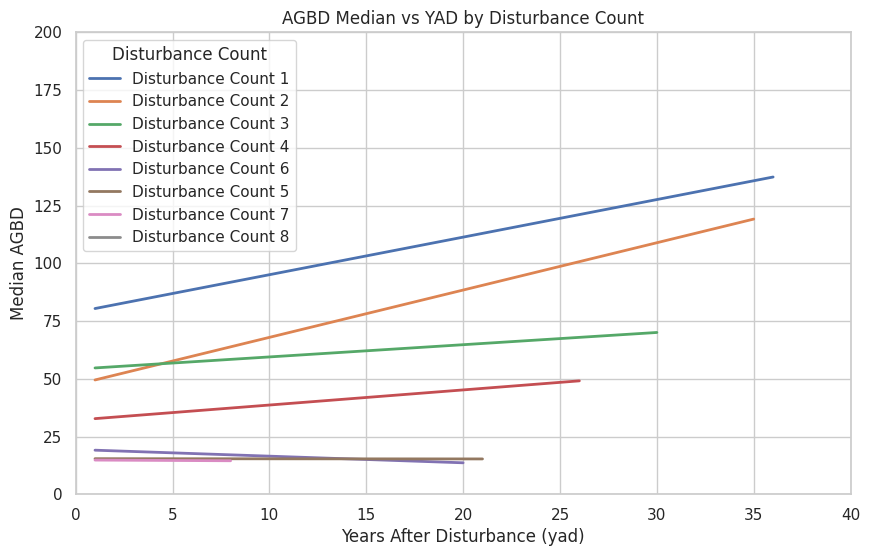

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Set style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Filter the data to include only yad > 0
# filtered_data = plot_test_dt[(plot_test_dt['dist_count'] == 1) & (plot_test_dt['yad'] > 0) & (figure_data['N'] >0)]

# Get unique disturbance counts
dist_counts = plot_test_dt['dist_count'].unique()

pred_list = []
dist_slope_int_list = []
# Plot each disturbance count separately
for dist_count in dist_counts:

    # Filter data for the current disturbance count
    data_subset = filtered_data[filtered_data['dist_count'] == dist_count]
    # data_subset = filtered_data
    print(data_subset.shape)
    # Perform linear regression on the subset
    X = data_subset['yad'].values.reshape(-1, 1)
    y = data_subset['agbd'].values

    model = LinearRegression().fit(X, y)

    # Generate predictions only for the range of X
    X_pred = X
    y_pred = model.predict(X_pred)

    # Calculate R² score
    r2 = r2_score(y, model.predict(X))
    print(f"Disturbance Count {dist_count} - R²: {r2:.2f}")

    # Calculate p-value
    n = len(y)
    p = X.shape[1] if X.ndim > 1 else 1

    # Calculate residual sum of squares and total sum of squares
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    total_sum_of_squares = np.sum((y - np.mean(y)) ** 2)

    # Calculate F-statistic
    f_statistic = (r2 / p) / ((1 - r2) / (n - p - 1))

    # Calculate p-value using the F-distribution survival function
    p_value = stats.f.sf(f_statistic, p, n - p - 1)

    print(f"P-value: {p_value:.5f}")
    # Plot the line within the actual data range
    plt.plot(X_pred, y_pred, label=f"Disturbance Count {dist_count}", linewidth=2)

    # set_y_pred

    data_subset['agbd_pred_lm'] =  model.predict(X)
    pred_list.append(data_subset)

    dist_slope_int_list.append([dist_count,model.coef_[0],model.intercept_])
# Set plot limits and labels
plt.xlim(0, 40)
plt.ylim(0, 200)
plt.xlabel('Years After Disturbance (yad)')
plt.ylabel('Median AGBD')
plt.title('AGBD Median vs YAD by Disturbance Count')
plt.legend(title='Disturbance Count')
plt.show()


In [39]:
result = pd.concat(pred_list)

In [40]:
# result

Disturbance Count 8 - R²: 0.73


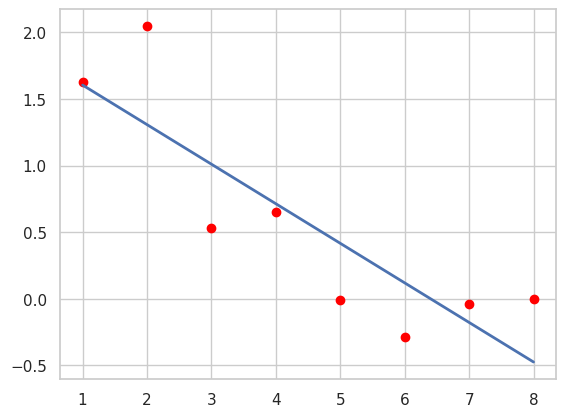

In [41]:
# Perform linear regression on the subset
X = np.array([element[0] for element in dist_slope_int_list]).reshape(-1, 1)
y = np.array([element[1] for element in dist_slope_int_list]).reshape(-1, 1)

model = LinearRegression().fit(X, y)

# Generate predictions only for the range of X
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(X_pred)

# Calculate R² score
r2 = r2_score(y, model.predict(X))
print(f"Disturbance Count {dist_count} - R²: {r2:.2f}")

plt.scatter(X, y, color='red', label="Points")
# Plot the line within the actual data range
plt.plot(X_pred, y_pred, label=f"Disturbance Count {dist_count}", linewidth=2)

In [42]:
rf_ready = result[keep_columns]
rf_ready['agbd_dif'] = ((result["agbd"] - result['agbd_pred_lm'])*2)/(result["agbd_pred_lm"] +result["agbd"])

In [43]:
y = rf_ready[['agbd_dif','agbd']]
# y_agbd = rf_ready['agbd']
X = rf_ready.drop(columns=['agbd_dif','agbd','dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
       'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
       'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std','dist_count', 'dist_instance',  ])

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_iris

# # Load a sample dataset (Iris dataset)
# data = load_iris()
# X = data.data  # Features
# y = data.target  # Labels

# Split the data into training and testing sets
# _, _, _, y_agbd_test = train_test_split(X, y_agbd, test_size=0.3, random_state=42)
X_train_all, X_test_all, y_train, y_test = train_test_split(rf_ready, y, test_size=0.3, random_state=42)

X_train = X_train_all.drop(columns=['agbd_dif','agbd','dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
       'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
       'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std','dist_count', 'dist_instance',  ])

X_test = X_test_all.drop(columns=['agbd_dif','agbd','dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
       'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
       'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std','dist_count', 'dist_instance',  ])

y_agbd_train = y_train['agbd']
y_agbd_test = y_test['agbd']

y_train = y_train['agbd_dif']
y_test = y_test['agbd_dif']

# Initialize the Random Forest classifier
rf_classifier = RandomForestRegressor(n_estimators=100)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.2505279327148302
R^2 Score: 0.49276503321173815


In [45]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

           Feature  Importance
0   mean.elevation    0.294629
1       mean.slope    0.183417
2      mean.aspect    0.053218
3         tpi_gpkg    0.049907
6             pdsi    0.047990
12             swe    0.036826
11            srad    0.034998
17              vs    0.032764
16             vpd    0.030874
10            soil    0.030229
14            tmmx    0.029777
5              def    0.028870
13            tmmn    0.027332
15             vap    0.025038
9               ro    0.024804
4              aet    0.023542
8               pr    0.023347
7              pet    0.022438


In [46]:
region_points = gpd.read_file('/content/drive/MyDrive/HJA_Resources/summary_grid_env_var.gpkg')

In [47]:
region_points['z_score'] = rf_classifier.predict(region_points.reindex(columns=rf_classifier.feature_names_in_))

In [48]:
region_points.to_file('/content/drive/MyDrive/HJA_Resources/summary_grid_env_var_z_score.gpkg')

In [49]:

# Perform the intersection
intersection = gpd.overlay(study.to_crs(region_points.crs), region_points, how='intersection')

# Summarize one column by another
# Example: Summing values in 'value_column' grouped by 'group_column'
summary = intersection.groupby('HUC12')['z_score'].mean().reset_index()


In [50]:
study['z_score'] = summary['z_score']

In [51]:
study.to_file('HUC12_summarized_z_score.gpkg')

1009.1546640703755


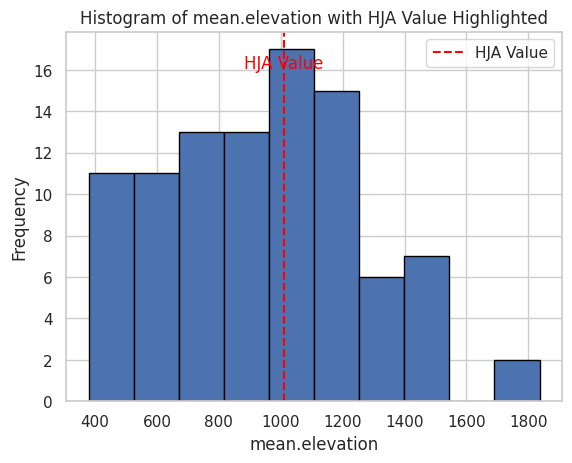

21.729231024301182


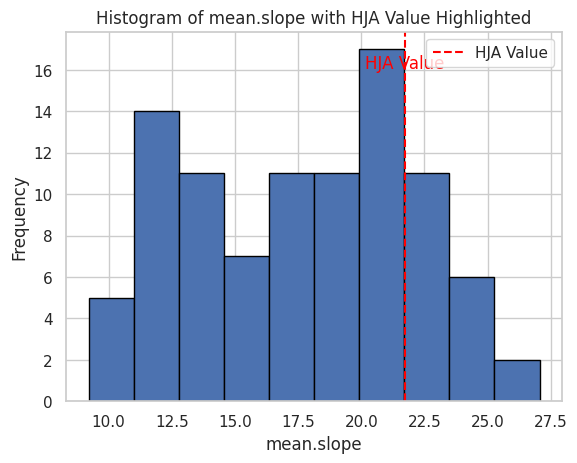

198.60782475625314


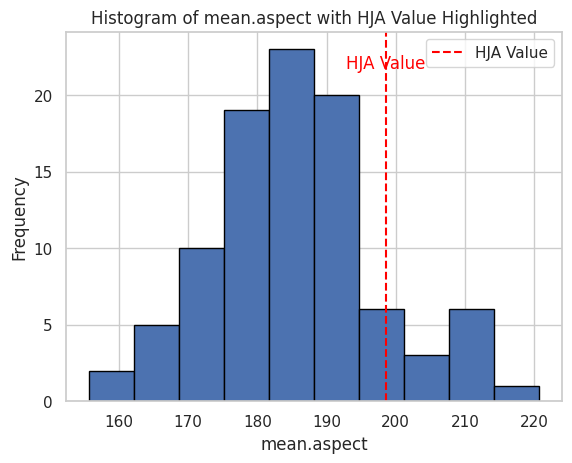

13.831583599890433


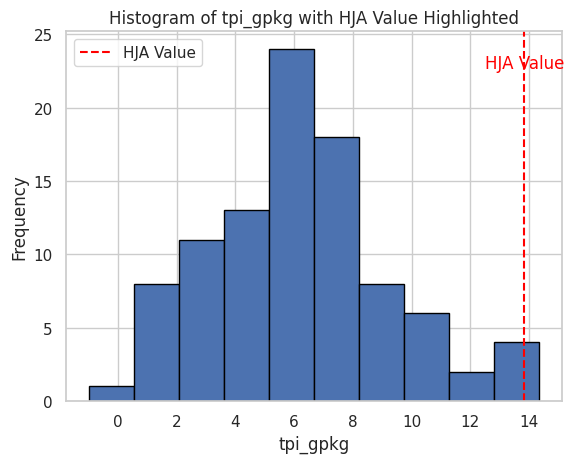

-21.85696513678438


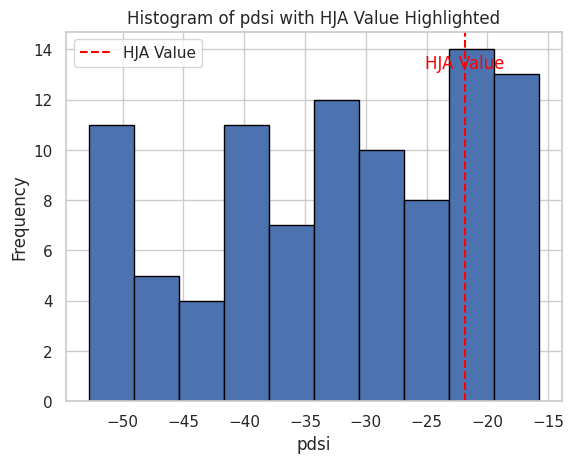

1620.9412343014953


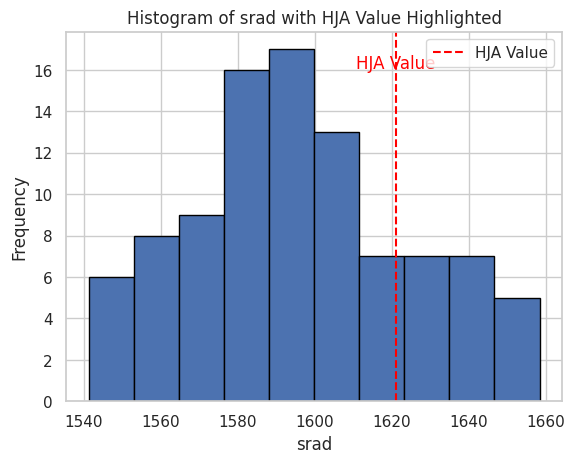

0.23706922881783135


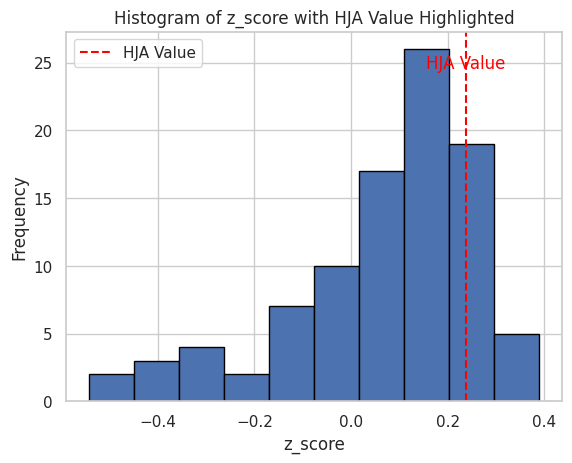

In [52]:
# Selected features to plot
features = ['mean.elevation', 'mean.slope', 'mean.aspect', 'tpi_gpkg', 'pdsi', 'srad','z_score']

# Generating a histogram for each selected feature with HJA feature value highlighted
for feature in features:
    summary = intersection.groupby('HUC12')[feature].mean().reset_index()
    HJA_val = summary[feature][summary['HUC12'] == '170900040401'].values[0]
    print(HJA_val)
    plt.figure()
    plt.hist(summary[feature], bins=10, edgecolor='black')
    plt.axvline(HJA_val, color='red', linestyle='--', label='HJA Value')
    plt.text(HJA_val, plt.ylim()[1] * 0.9, 'HJA Value', color='red', ha='center')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} with HJA Value Highlighted')
    plt.legend()
    plt.show()


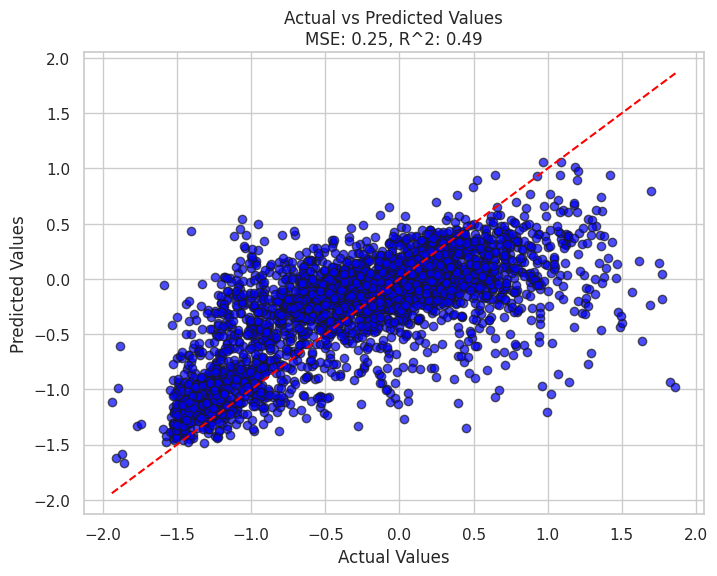

In [53]:

# Plot the predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values\nMSE: {mse:.2f}, R^2: {r2:.2f}')
plt.grid(True)
plt.show()

In [54]:
[i for i in disturbance.columns]

['fid',
 'agbd',
 'lat_lowestmode',
 'lon_lowestmode',
 'agbd_pi_lower',
 'agbd_pi_upper',
 'agbd_se',
 'agbd_t',
 'agbd_t_se',
 'algorithm_run_flag',
 'channel',
 'degrade_flag',
 'delta_time',
 'elev_lowestmode',
 'l2_quality_flag',
 'l4_quality_flag',
 'X',
 'Y',
 'OBJECTID',
 'TNMID',
 'MetaSourceID',
 'SourceDataDesc',
 'SourceOriginator',
 'SourceFeatureID',
 'LoadDate',
 'GNIS_ID',
 'AreaAcres',
 'AreaSqKm',
 'States',
 'HUC12',
 'Name',
 'HUType',
 'HUMod',
 'ToHUC',
 'NonContributingAreaAcres',
 'NonContributingAreaSqKm',
 'Shape_Length',
 'Shape_Area',
 'OBJECTID.1',
 'TNMID.1',
 'MetaSourceID.1',
 'SourceDataDesc.1',
 'SourceOriginator.1',
 'SourceFeatureID.1',
 'LoadDate.1',
 'GNIS_ID.1',
 'AreaAcres.1',
 'AreaSqKm.1',
 'States.1',
 'HUC10',
 'Name.1',
 'HUType.1',
 'HUMod.1',
 'Shape_Length.1',
 'Shape_Area.1',
 'OBJECTID.2',
 'TNMID.2',
 'MetaSourceID.2',
 'SourceDataDesc.2',
 'SourceOriginator.2',
 'SourceFeatureID.2',
 'LoadDate.2',
 'GNIS_ID.2',
 'AreaAcres.2',
 'AreaS

In [55]:
disturbance['dist_id']

,dist_id
0,9082
1,9082
2,9082
3,9133
4,9133
...,...
893138,199876
893139,199876
893140,199876
893141,199876


In [56]:
HJA_summary.columns

Index(['Unnamed: 0', 'agbd', 'lat_lowestmode', 'lon_lowestmode',
       'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'agbd_t', 'agbd_t_se',
       'algorithm_run_flag', 'channel', 'degrade_flag', 'delta_time',
       'elev_lowestmode', 'l2_quality_flag', 'l4_quality_flag', 'gedi_year',
       'min_yod', 'min_mag', 'min_dur', 'min_preval', 'min_rate', 'min_dsnr',
       'max_yod', 'max_mag', 'max_dur', 'max_preval', 'max_rate', 'max_dsnr',
       'mean_yod', 'mean_mag', 'mean_dur', 'mean_preval', 'mean_rate',
       'mean_dsnr', 'median_yod', 'median_mag', 'median_dur', 'median_preval',
       'median_rate', 'median_dsnr', 'min_hja_2008', 'max_hja_2008',
       'mean_hja_2008', 'median_hja_2008', 'min_conus_2003', 'max_conus_2003',
       'mean_conus_2003', 'median_conus_2003', 'min_conus_2016',
       'max_conus_2016', 'mean_conus_2016', 'median_conus_2016', 'gedi_vec_id',
       'gedi_vec_year', 'gedi_vec_area', 'FIRE_INC_ID', 'FIRE_NAME',
       'FIRE_YEAR', 'geom', 'HUC8', 'HUC10', 

In [57]:
study_full_disturbance
HJA_only_wnf_dist

,OBJECTID,TNMID,MetaSourceID,SourceDataDesc,SourceOriginator,SourceFeatureID,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,...,SPECT_TYPE,TIMBER_TYP,COND_CLASS,HAB_FEATUR,CVR_PCT_TR,PLANT_ASSC,ECOCLASS,geometry,area_orig,area_int_calc
0,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DH,MS,None,0,CH,None,"POLYGON ((-122.16774 44.20156, -122.16776 44.2...",6.751547e+04,219.042907
1,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DH,GS,None,60,None,None,"POLYGON ((-122.16576 44.20229, -122.16606 44.2...",5.607828e+03,1162.033546
2,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DH,GS,None,50,None,None,"MULTIPOLYGON (((-122.14796 44.20332, -122.1479...",2.796859e+03,136.875071
3,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DH,SS,None,0,CD,None,"POLYGON ((-122.1145 44.20313, -122.11487 44.20...",6.561953e+03,4842.442474
4,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DH,LS,None,0,CH,None,"POLYGON ((-122.16714 44.20157, -122.16715 44.2...",6.357979e+05,0.371680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NF,DT,NF,None,0,CF,None,"POLYGON ((-122.14353 44.28125, -122.14337 44.2...",1.858000e+03,315.333110
393,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NF,NF,NF,MD,0,None,None,"POLYGON ((-122.14714 44.27968, -122.14679 44.2...",9.099934e+04,33408.709429
394,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NF,NF,NF,RO,0,None,None,"POLYGON ((-122.14487 44.2811, -122.14434 44.28...",1.735759e+04,3931.531086
395,3160,{1472BA10-5C01-437A-8AAF-A4611746157E},None,None,None,None,2013-01-18 07:09:30+00:00,NaN,15735.63,63.68,...,NS,DT,MS,None,0,None,None,"POLYGON ((-122.14487 44.2811, -122.14487 44.28...",2.191959e+04,61.490073


In [58]:
HJA_only_wnf_dist['wnf_stand'] = HJA_only_wnf_dist.STAND

HJA_only_wnf_dist['wnf_year'] = HJA_only_wnf_dist.YR_ORIGIN

HJA_area = study[study['HUC12'] == '170900040401'].to_crs(26910).area.values[0]

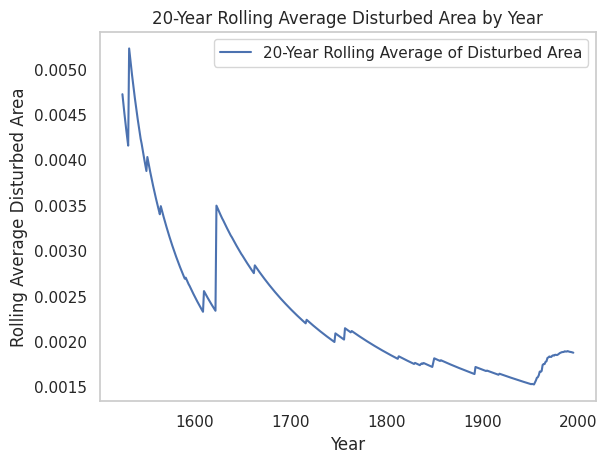

In [59]:
# Group by 'wnf_stand' and 'wnf_year', count occurrences, and sum the AREA
disturbance_df = HJA_only_wnf_dist[HJA_only_wnf_dist['wnf_year'] != 0].groupby(['wnf_year']).agg(
    frequency=('wnf_year', 'size'),
    average_area=('area_int_calc', 'mean'),
    total_area=('area_int_calc', 'sum'),
).reset_index()

disturbance_df['study_area'] = HJA_area

disturbance_df['percent_area'] = disturbance_df['total_area']/disturbance_df['study_area']
# Calculate the area-adjusted frequency
# disturbance_df['area_adjusted_frequency'] = disturbance_df['average_area']*disturbance_df['frequency']
# Ensure a continuous time series with 1-year increments
df_full = pd.DataFrame({'wnf_year': range(disturbance_df["wnf_year"].min(), disturbance_df["wnf_year"].max() + 1)})
df_full = df_full.merge(disturbance_df, on='wnf_year', how='left').fillna(0)

df_full["rolling_avg_percent"] = df_full["percent_area"].rolling(window=600, min_periods=1).mean()

start_year =1525
# Plot the rolling average disturbed area by year
plt.plot(df_full[df_full["wnf_year"] >= start_year]["wnf_year"], df_full[df_full["wnf_year"] >= start_year]["rolling_avg_percent"], label='20-Year Rolling Average of Disturbed Area')
plt.xlabel("Year")
plt.ylabel("Rolling Average Disturbed Area")
plt.title("20-Year Rolling Average Disturbed Area by Year")
plt.legend()
plt.grid()
plt.show()

In [60]:
df_full.tail(1)

,wnf_year,frequency,average_area,total_area,study_area,percent_area,rolling_avg_percent
513,1995,1.0,27250.63045,27250.63045,6.363573e+07,0.000428,0.001874


In [61]:
study_full_disturbance.columns

Index(['OBJECTID', 'TNMID', 'MetaSourceID', 'SourceDataDesc',
       'SourceOriginator', 'SourceFeatureID', 'LoadDate', 'GNIS_ID',
       'AreaAcres', 'AreaSqKm', 'States', 'HUC12', 'Name', 'HUType', 'HUMod',
       'ToHUC', 'NonContributingAreaAcres', 'NonContributingAreaSqKm',
       'Shape_Length', 'Shape_Area', 'DN', 'Area', 'Perimeter', 'Nodes',
       'geometry'],
      dtype='object')

In [62]:
study_full_disturbance['year'] = study_full_disturbance['DN']

In [63]:
study_area = np.sum(study.to_crs(26910).area)

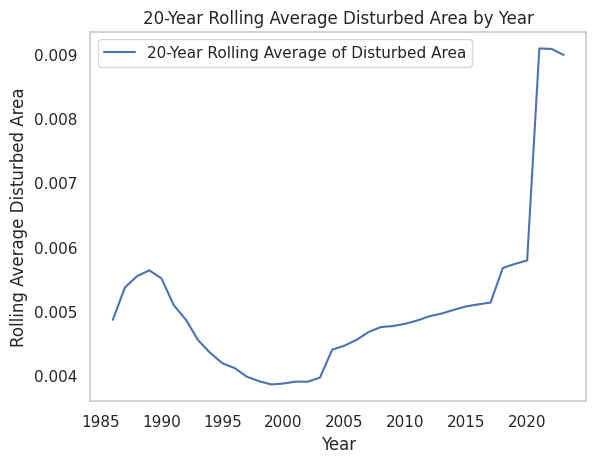

In [64]:
# Group by 'wnf_stand' and 'wnf_year', count occurrences, and sum the AREA
disturbance_df = study_full_disturbance[study_full_disturbance['year'] != 0].groupby(['year']).agg(
    frequency=('year', 'size'),
    average_area=('Area', 'mean'),
    total_area=('Area', 'sum'),
).reset_index()

disturbance_df['study_area'] = study_area

disturbance_df['percent_area'] = disturbance_df['total_area']/disturbance_df['study_area']
# Calculate the area-adjusted frequency
# disturbance_df['area_adjusted_frequency'] = disturbance_df['average_area']*disturbance_df['frequency']
# Ensure a continuous time series with 1-year increments
df_full = pd.DataFrame({'year': range(disturbance_df["year"].min(), disturbance_df["year"].max() + 1)})
df_full = df_full.merge(disturbance_df, on='year', how='left').fillna(0)

df_full["rolling_avg_percent"] = df_full["percent_area"].rolling(window=100, min_periods=1).mean()

start_year =1575
# Plot the rolling average disturbed area by year
plt.plot(df_full[df_full["year"] >= start_year]["year"], df_full[df_full["year"] >= start_year]["rolling_avg_percent"], label='20-Year Rolling Average of Disturbed Area')
plt.xlabel("Year")
plt.ylabel("Rolling Average Disturbed Area")
plt.title("20-Year Rolling Average Disturbed Area by Year")
plt.legend()
plt.grid()
plt.show()

In [65]:
X_test_all.columns

Index(['agbd', 'dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
       'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
       'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std', 'mean.elevation',
       'mean.slope', 'mean.aspect', 'tpi_gpkg', 'aet', 'def', 'pdsi', 'pet',
       'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs',
       'dist_count', 'dist_instance', 'agbd_dif'],
      dtype='object')

In [66]:
dist_slope_int_list

[[1, 1.626914783411445, 78.76690792791868],
 [2, 2.048613857651293, 47.42543229107747],
 [3, 0.5293798628992156, 54.151826054053046],
 [4, 0.654249465686036, 32.08018742231291],
 [6, -0.28751534588152156, 19.363667739588145],
 [5, -0.005108647919542959, 15.397086838069765],
 [7, -0.041959791693073144, 14.834743638075048],
 [8, 0.0, 14.327784538269]]

In [67]:

# # Define dist_slope_int_list as a dictionary for quick lookup
dist_slope_int_dict = {entry[0]: {'slope': entry[1], 'intercept': entry[2]} for entry in dist_slope_int_list}

# Sample validation data (structure only, use your actual data here)
validation_df = pd.DataFrame({
    'disturbance_instance': X_test_all['dist_count'],  # Example instances
    'yad': X_test_all['yad'],  # Years after disturbance
    'z_score_pred_rf': y_pred # Random forest predictions for Z-scores
})

# Calculate the linear model predictions based on 'yad' for each disturbance instance
validation_df['agbd_pred_lm'] = validation_df.apply(
    lambda row: dist_slope_int_dict[row['disturbance_instance']]['slope'] * row['yad']
                + dist_slope_int_dict[row['disturbance_instance']]['intercept'],
    axis=1
)

# Reverse the Z-score to get the reconstructed agbd (original biomass)
validation_df['agbd_reconstructed'] = (
    (validation_df['z_score_pred_rf'] * validation_df['agbd_pred_lm'] + 2 * validation_df['agbd_pred_lm']) /
    (2 - validation_df['z_score_pred_rf'])
)

validation_df['agbd'] = y_agbd_test

# Display the DataFrame with reconstructed biomass
print(validation_df[['disturbance_instance', 'yad', 'z_score_pred_rf','agbd', 'agbd_pred_lm', 'agbd_reconstructed']])

       disturbance_instance  yad  z_score_pred_rf        agbd  agbd_pred_lm  \
3045                      1    5        -0.023817   87.862193     86.901482   
4960                      1   11        -0.046460  128.667347     96.662971   
10494                     1   30         0.319469  207.250425    127.574351   
1553                      1    1        -0.052366   60.119535     80.393823   
5503                      3   13        -0.668277   14.835063     61.033764   
...                     ...  ...              ...         ...           ...   
1914                      1    2        -0.878474   52.574188     82.020737   
3822                      4    8        -0.625492   14.620788     37.314183   
4267                      2    9        -0.107296   37.942572     65.862957   
4787                      2   11        -0.319910   41.970494     69.960185   
8087                      1   21        -0.099916  128.234333    112.932118   

       agbd_reconstructed  
3045            84.8561

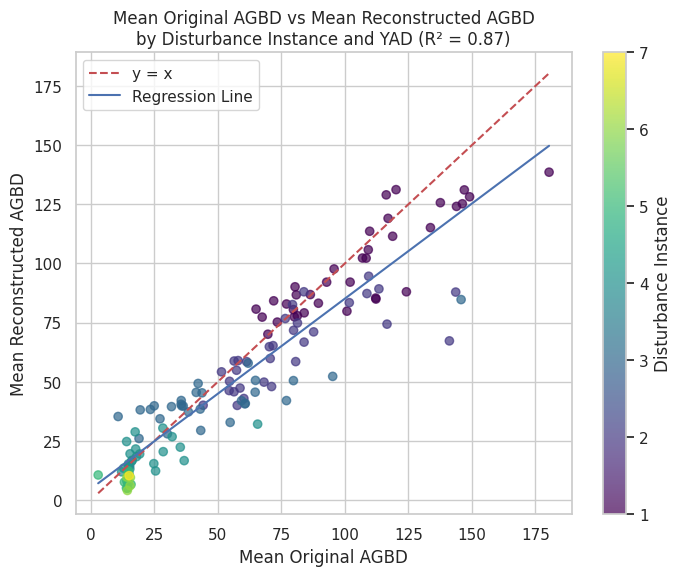

                               OLS Regression Results                              
Dep. Variable:     mean_agbd_reconstructed   R-squared:                       0.866
Model:                                 OLS   Adj. R-squared:                  0.865
Method:                      Least Squares   F-statistic:                     860.6
Date:                     Thu, 21 Nov 2024   Prob (F-statistic):           6.20e-60
Time:                             16:57:23   Log-Likelihood:                -535.95
No. Observations:                      135   AIC:                             1076.
Df Residuals:                          133   BIC:                             1082.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Summarize data by taking the mean for each combination of disturbance_instance and yad
summary_df = validation_df[validation_df['agbd'] <= 400].groupby(['disturbance_instance', 'yad']).agg(
    mean_agbd=('agbd', 'mean'),
    mean_agbd_reconstructed=('agbd_reconstructed', 'mean')
).reset_index()

# Running a regression of mean_agbd_reconstructed on mean_agbd
X = summary_df['mean_agbd']
X = sm.add_constant(X)  # Adds a constant term to the model
y = summary_df['mean_agbd_reconstructed']

# Fit the regression model
model = sm.OLS(y, X).fit()
r_squared = model.rsquared  # Get R-squared value

# Generate regression line values
mean_agbd_range = np.linspace(summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max(), 100)
regression_line = model.predict(sm.add_constant(mean_agbd_range))

# Plotting summarized 'mean_agbd' vs 'mean_agbd_reconstructed', colored by disturbance_instance
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    summary_df['mean_agbd'],
    summary_df['mean_agbd_reconstructed'],
    c=summary_df['disturbance_instance'],
    cmap='viridis',  # Choose a color map
    alpha=0.7
)

# Plot the reference line y=x
plt.plot([summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max()],
         [summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max()], 'r--', label='y = x')

# Plot the regression line
plt.plot(mean_agbd_range, regression_line, 'b-', label='Regression Line')

# Add color bar for disturbance_instance
cbar = plt.colorbar(scatter)
cbar.set_label('Disturbance Instance')

# Set labels and title with R-squared
plt.xlabel('Mean Original AGBD')
plt.ylabel('Mean Reconstructed AGBD')
plt.title(f'Mean Original AGBD vs Mean Reconstructed AGBD\nby Disturbance Instance and YAD (R² = {r_squared:.2f})')
plt.legend()
plt.grid(True)

# Show th plot
plt.show()
# Print reression summary
print(model.summary())


In [69]:
from sklearn.ensemble import RandomForestRegressor

# Prepare your features and targets
y = rf_ready['agbd_dif']  # Use 'agbd_dif' as the target
X = rf_ready.drop(columns=['agbd_dif', 'agbd', 'dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
                            'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
                            'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std',
                            'dist_count', 'dist_instance'])

# Train on the full dataset with OOB predictions enabled
rf_classifier = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# Fit the random forest model on the entire dataset
rf_classifier.fit(X, y)

# Retrieve the OOB predictions
oob_predictions = rf_classifier.oob_prediction_

# Print the OOB R^2 score
print("OOB R^2 Score (Unbiased Evaluation):", rf_classifier.oob_score_)

# Optional: Predict on the entire dataset (may be overfit)
full_predictions = rf_classifier.predict(X)

# Now you can use oob_predictions as your unbiased predictions for further analysis.

OOB R^2 Score (Unbiased Evaluation): 0.5150995746240687


In [70]:
rf_ready.head()

,agbd,dist_id,yad,HUC8,HUC10,HUC12,mag_mean,mag_std,dur_mean,dur_std,...,srad,swe,tmmn,tmmx,vap,vpd,vs,dist_count,dist_instance,agbd_dif
1476,61.189609,19542.154762,1,17090003,1709000301,170900030101,334.357030,65.605189,1.0,0.0,...,1594.108587,0.004597,60.809753,177.198798,965.274255,63.933361,312.182892,1,1.0,-0.271278
1478,47.006680,19831.930233,1,17090003,1709000301,170900030102,337.799721,66.150126,1.0,0.0,...,1595.011632,0.003876,63.656654,177.973514,961.433460,66.012920,312.356267,1,1.0,-0.524129
1480,39.391048,19935.537736,1,17090003,1709000301,170900030103,365.352928,78.986078,1.0,0.0,...,1580.930383,0.004586,64.313155,178.991391,1000.463433,62.818606,310.484670,1,1.0,-0.684607
1483,153.111045,18618.919355,1,17090003,1709000301,170900030104,337.508984,71.491793,1.0,0.0,...,1566.723299,0.012391,60.167861,171.899584,978.272886,57.691869,310.797957,1,1.0,0.622833
1486,142.655665,18870.346667,1,17090003,1709000301,170900030105,353.918506,77.799007,1.0,0.0,...,1563.967638,0.002593,59.136204,169.953744,969.631142,56.349210,314.823034,1,1.0,0.558278


In [71]:
rf_ready['z_score_pred_rf'] = oob_predictions

In [72]:
dist_slope_int_list.append([11,3.51,14.32])

In [85]:
dist_slope_int_list.append([12,4.15,23.67])
dist_slope_int_list.append([13,4.42,-26.21])
dist_slope_int_list.append([14,4.68,9.69])

In [86]:
# GEDI (0-100): y = 4.15x + 23.67, R² = 0.40
# ALS, 2008 (0-100): y = 4.42x + -26.21, R² = 0.60
# LS, 2016 (0-100): y = 4.68x + 9.69, R² = 0.46
# ALS, 2008 (0-200): y = 3.51x + 14.32, R² = 0.83
# ALS, 2008 (100-200): y = 5.69x + -352.49, R² = 0.60
# ALS, 2008 (100-200): y = -0.86x + 967.68, R² = 0.10

In [93]:
dist_slope_int_list

[[1, 1.626914783411445, 78.76690792791868],
 [2, 2.048613857651293, 47.42543229107747],
 [3, 0.5293798628992156, 54.151826054053046],
 [4, 0.654249465686036, 32.08018742231291],
 [6, -0.28751534588152156, 19.363667739588145],
 [5, -0.005108647919542959, 15.397086838069765],
 [7, -0.041959791693073144, 14.834743638075048],
 [8, 0.0, 14.327784538269],
 [11, 3.51, 14.32],
 [12, 4.15, 23.67],
 [13, 4.42, -26.21],
 [14, 4.68, 9.69]]

In [94]:

# # Define dist_slope_int_list as a dictionary for quick lookup
dist_slope_int_dict = {entry[0]: {'slope': entry[1], 'intercept': entry[2]} for entry in dist_slope_int_list}

# Sample validation data (structure only, use your actual data here)
validation_df = pd.DataFrame({
    'disturbance_instance': [i for i in rf_ready['dist_count']],  # Example instances
    'HJA_form': [11 for i in rf_ready['dist_count']],  # Example instances
    'yad': rf_ready['yad'],  # Years after disturbance
    'z_score_pred_rf': rf_ready['z_score_pred_rf'] , # Random forest predictions for Z-scores
    'HUC8': rf_ready['HUC8'] ,
    'HUC10': rf_ready['HUC10'] ,
    'HUC12': rf_ready['HUC12'] ,
})

# Calculate the linear model predictions based on 'yad' for each disturbance instance
validation_df['agbd_pred_lm'] = validation_df.apply(
    lambda row: dist_slope_int_dict[row['disturbance_instance']]['slope'] * row['yad']
                + dist_slope_int_dict[row['disturbance_instance']]['intercept'],
    axis=1
)

# Calculate the linear model predictions based on 'yad' for each disturbance instance
validation_df['agbd_pred_lm_hja'] = validation_df.apply(
    lambda row: dist_slope_int_dict[row['HJA_form']]['slope'] * row['yad']
                + dist_slope_int_dict[row['HJA_form']]['intercept'],
    axis=1
)

# Calculate the linear model predictions based on 'yad' for each disturbance instance
validation_df['agbd_pred_lm_initial'] = validation_df.apply(
    lambda row: dist_slope_int_dict[row['disturbance_instance']]['slope'] * 0
                + dist_slope_int_dict[row['disturbance_instance']]['intercept'],
    axis=1
)

# Calculate the linear model predictions based on 'yad' for each disturbance instance
validation_df['agbd_pred_lm_initial_hja'] = validation_df.apply(
    lambda row: dist_slope_int_dict[row['HJA_form']]['slope'] * 0
                + dist_slope_int_dict[row['HJA_form']]['intercept'],
    axis=1
)

# Reverse the Z-score to get the reconstructed agbd (original biomass)
validation_df['agbd_reconstructed'] = (
    (validation_df['z_score_pred_rf'] * validation_df['agbd_pred_lm'] + 2 * validation_df['agbd_pred_lm']) /
    (2 - validation_df['z_score_pred_rf'])
)

# Reverse the Z-score to get the reconstructed agbd (original biomass)
validation_df['agbd_initial_reconstructed'] = (
    (validation_df['z_score_pred_rf'] * validation_df['agbd_pred_lm_initial'] + 2 * validation_df['agbd_pred_lm_initial']) /
    (2 - validation_df['z_score_pred_rf'])
)

validation_df['rate_reconstructed'] = (validation_df['agbd_reconstructed']-validation_df['agbd_initial_reconstructed'])/validation_df['yad']

# Reverse the Z-score to get the reconstructed agbd (original biomass)
validation_df['agbd_reconstructed_hja'] = (
    (validation_df['z_score_pred_rf'] * validation_df['agbd_pred_lm_hja'] + 2 * validation_df['agbd_pred_lm_hja']) /
    (2 - validation_df['z_score_pred_rf'])
)

# Reverse the Z-score to get the reconstructed agbd (original biomass)
validation_df['agbd_initial_reconstructed_hja'] = (
    (validation_df['z_score_pred_rf'] * validation_df['agbd_pred_lm_initial_hja'] + 2 * validation_df['agbd_pred_lm_initial_hja']) /
    (2 - validation_df['z_score_pred_rf'])
)

validation_df['rate_reconstructed_hja'] = (validation_df['agbd_reconstructed_hja']-validation_df['agbd_initial_reconstructed_hja'])/validation_df['yad']


validation_df['agbd'] = y_agbd_test

# Display the DataFrame with reconstructed biomass
print(validation_df)

      disturbance_instance  HJA_form  yad  z_score_pred_rf      HUC8  \
1476                     1        11    1        -0.266728  17090003   
1478                     1        11    1        -0.143479  17090003   
1480                     1        11    1        -0.561948  17090003   
1483                     1        11    1        -0.066425  17090003   
1486                     1        11    1         0.428846  17090003   
...                    ...       ...  ...              ...       ...   
1501                     7        11    1        -0.424182  17090003   
2375                     7        11    3        -0.597494  17090005   
3637                     7        11    7        -0.750847  17090005   
3740                     7        11    8        -0.421102  17090003   
2557                     8        11    4        -0.969333  17090003   

           HUC10         HUC12  agbd_pred_lm  agbd_pred_lm_hja  \
1476  1709000301  170900030101     80.393823             17.83   
147

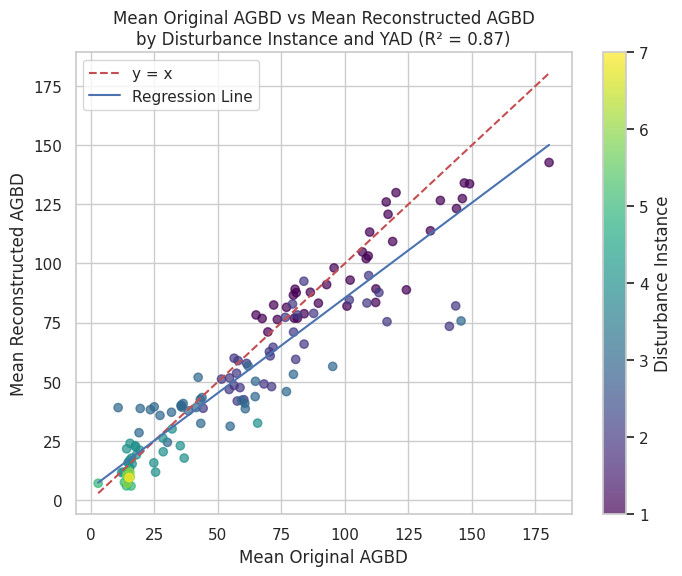

                               OLS Regression Results                              
Dep. Variable:     mean_agbd_reconstructed   R-squared:                       0.868
Model:                                 OLS   Adj. R-squared:                  0.867
Method:                      Least Squares   F-statistic:                     871.3
Date:                     Thu, 21 Nov 2024   Prob (F-statistic):           3.03e-60
Time:                             18:23:10   Log-Likelihood:                -535.21
No. Observations:                      135   AIC:                             1074.
Df Residuals:                          133   BIC:                             1080.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Summarize data by taking the mean for each combination of disturbance_instance and yad
summary_df = validation_df[validation_df['agbd'] <= 400].groupby(['disturbance_instance', 'yad']).agg(
    mean_agbd=('agbd', 'mean'),
    mean_agbd_reconstructed=('agbd_reconstructed', 'mean')
).reset_index()

# Running a regression of mean_agbd_reconstructed on mean_agbd
X = summary_df['mean_agbd']
X = sm.add_constant(X)  # Adds a constant term to the model
y = summary_df['mean_agbd_reconstructed']

# Fit the regression model
model = sm.OLS(y, X).fit()
r_squared = model.rsquared  # Get R-squared value

# Generate regression line values
mean_agbd_range = np.linspace(summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max(), 100)
regression_line = model.predict(sm.add_constant(mean_agbd_range))

# Plotting summarized 'mean_agbd' vs 'mean_agbd_reconstructed', colored by disturbance_instance
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    summary_df['mean_agbd'],
    summary_df['mean_agbd_reconstructed'],
    c=summary_df['disturbance_instance'],
    cmap='viridis',  # Choose a color map
    alpha=0.7
)

# Plot the reference line y=x
plt.plot([summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max()],
         [summary_df['mean_agbd'].min(), summary_df['mean_agbd'].max()], 'r--', label='y = x')

# Plot the regression line
plt.plot(mean_agbd_range, regression_line, 'b-', label='Regression Line')

# Add color bar for disturbance_instance
cbar = plt.colorbar(scatter)
cbar.set_label('Disturbance Instance')

# Set labels and title with R-squared
plt.xlabel('Mean Original AGBD')
plt.ylabel('Mean Reconstructed AGBD')
plt.title(f'Mean Original AGBD vs Mean Reconstructed AGBD\nby Disturbance Instance and YAD (R² = {r_squared:.2f})')
plt.legend()
plt.grid(True)

# Show th plot
plt.show()
# Print reression summary
print(model.summary())

In [111]:
rf_ready.columns

Index(['agbd', 'dist_id', 'yad', 'HUC8', 'HUC10', 'HUC12', 'mag_mean',
       'mag_std', 'dur_mean', 'dur_std', 'preval_mean', 'preval_std',
       'rate_mean', 'rate_std', 'dsnr_mean', 'dsnr_std', 'mean.elevation',
       'mean.slope', 'mean.aspect', 'tpi_gpkg', 'aet', 'def', 'pdsi', 'pet',
       'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs',
       'dist_count', 'dist_instance', 'agbd_dif', 'z_score_pred_rf'],
      dtype='object')

In [106]:
# study

In [107]:
# validation_df.group_by('')
summary = validation_df.groupby('HUC12', as_index=False)[['rate_reconstructed','rate_reconstructed_hja']].mean().reset_index()

study['HUC12'] = study['HUC12'].astype(str)
summary['HUC12'] = summary['HUC12'].astype(str)

# Step 2: Merge the summary with dataset 2
merged_df = pd.merge(study, summary, on='HUC12')

In [109]:
merged_df.to_file("result.gpkg")